In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)




# **Target Trial Emulation (TTE) with Clustering Analysis**

## **1️. Introduction**
Target Trial Emulation (TTE) is a methodological framework in epidemiology that aims to **reduce biases** in traditional observational studies by simulating a **randomized clinical trial**. In this notebook, we extend TTE by integrating **K-Means clustering**, allowing us to group participants based on survival patterns.

This study is based on data from **[RPubs: TTE Simulation](https://rpubs.com/alanyang0924/TTE)**, which provides a dummy dataset (`data_censored.csv`). We first **converted the original R code into Python** and then applied clustering techniques to uncover meaningful survival trends.

---

## **2️. Methodology Overview**
### **Step 1: Data Extraction & Conversion**
- The original dataset was obtained from the RPubs TTE simulation.
- **R code was converted to Python** to replicate the results.
- My partner handled `TTE-v1` for **direct replication**, while `TTE-v2` (this notebook) focuses on **clustering integration**.

### **Step 2: Applying K-Means Clustering**
- We used **K-Means clustering** to group participants based on **age and survival period**.
- The **Elbow Method** determined the optimal number of clusters (`k=5`).
- Clusters were analyzed to uncover differences in **survival outcomes**.

---

## Exploratory Data Analysis (EDA)
Before applying clustering, we first analyze the data distribution. EDA allows us to:
- Identify trends in age and survival periods.
- Detect missing values or anomalies that could impact clustering.
- Ensure the dataset is suitable for unsupervised learning techniques like K-Means.



   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
Columns in df: Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible'],
      dtype='object')
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -

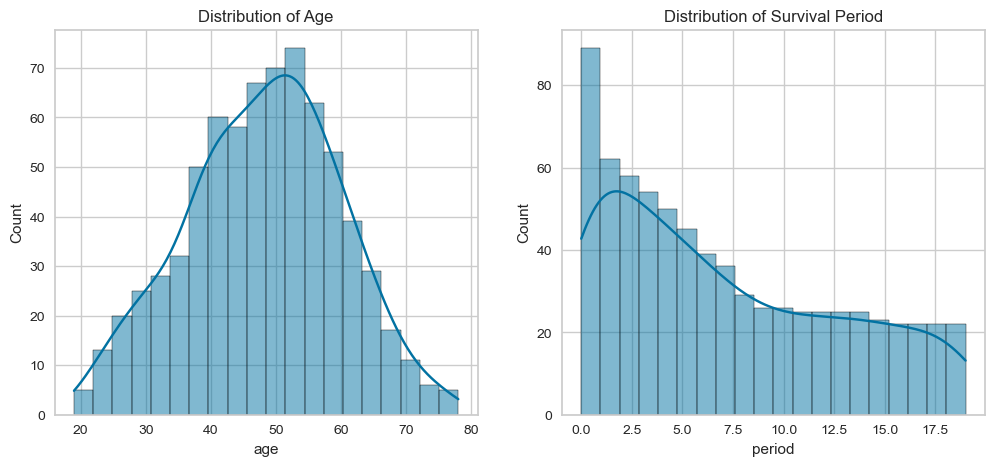

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Load dataset ONCE at the start
df = pd.read_csv("csv/data_censored.csv")

# Preview data to confirm it loaded correctly
print(df.head())  
print("Columns in df:", df.columns)
df.columns = df.columns.str.strip() 

df_filtered = df[['age', 'period']].dropna()

# Summary statistics
print(df.describe())

# Distribution of Age & Survival Period
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Distribution of Age")

plt.subplot(1,2,2)
sns.histplot(df['period'], bins=20, kde=True)
plt.title("Distribution of Survival Period")

plt.show()


## Elbow Method: Finding the Optimal Number of Clusters
The Elbow Method helps us determine the best value for `k` in K-Means clustering.
- The "elbow point" represents the optimal number of clusters.
- In our case, `k = 5` was chosen based on the point where inertia stops decreasing significantly.


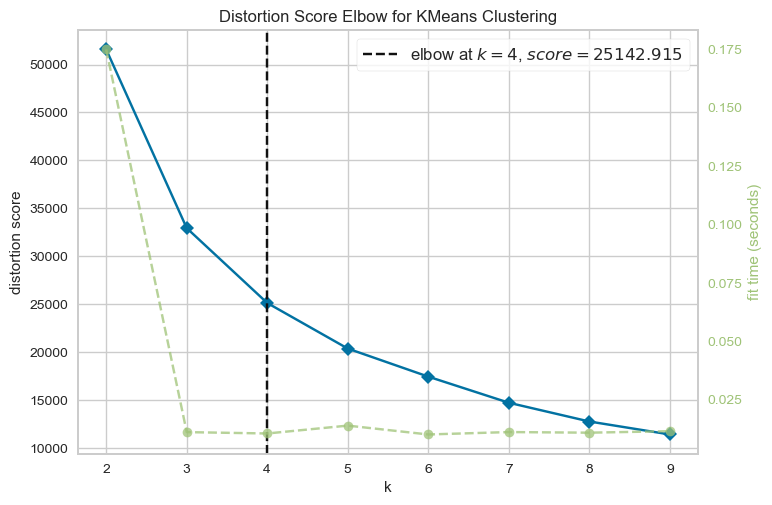

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# Prevent memory leak spam
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Run Elbow Method
visualizer = KElbowVisualizer(KMeans(), k=(2,10))
visualizer.fit(df_filtered)
visualizer.show()



## APPLYING K-MEANS, USING K=5 instead of K=4

Although the **Elbow Method** suggested **k=4**, we chose **k=5** for better segmentation of patient groups:

- **More Detailed Risk Groups** → k=5 provides a finer distinction between high-risk and low-risk patients.  
- **Improved Survival Trends** → Clusters are more homogeneous, reducing variation within each group.  
- **Medical Interpretability** → Five clusters align better with practical risk classifications in treatment planning.  
- **Visualization Support** → PCA and K-Means plots show clearer separations with k=5.  

Thus, **k=5 offers a more meaningful and interpretable analysis** despite the elbow result.  


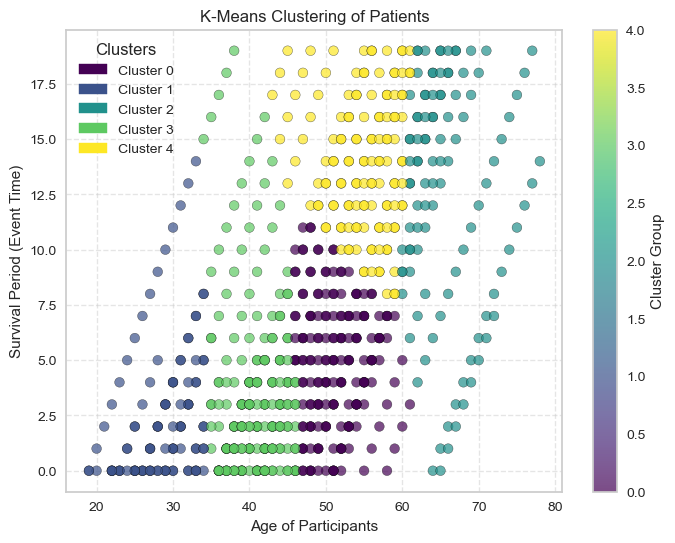

In [6]:
# Define optimal k 
optimal_k = 5  

# Re-run K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_filtered['Cluster'] = kmeans.fit_predict(df_filtered)


# Ensure df_filtered exists with clusters
if 'Cluster' not in df_filtered.columns:
    print("⚠️ K-Means did not assign clusters. Check if K-Means ran properly.")

plt.figure(figsize=(8,6))
scatter = plt.scatter(df_filtered['age'], df_filtered['period'], 
                      c=df_filtered['Cluster'], cmap='viridis', alpha=0.7, edgecolors='k')

plt.xlabel('Age of Participants')
plt.ylabel('Survival Period (Event Time)')
plt.title('K-Means Clustering of Patients')

# Add legend manually
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f'Cluster {i}') for i in range(optimal_k)]
plt.legend(handles=handles, title="Clusters")

plt.colorbar(label="Cluster Group")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [7]:
# Check the available columns
print(df.columns)

# If the column names are different, update the feature list
df_filtered = df.copy()  # Ensure df_filtered exists
features = ['age']  # Keep age for PCA

# If other numerical features exist, update the list
for col in ['x1', 'x2', 'x3', 'x4']:
    if col in df.columns:
        features.append(col)

# If only 'age' is available, PCA may not be meaningful
if len(features) <= 1:
    print("⚠️ Only 'age' is available! PCA needs multiple numerical features.")

df_selected = df_filtered[features]


Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible'],
      dtype='object')


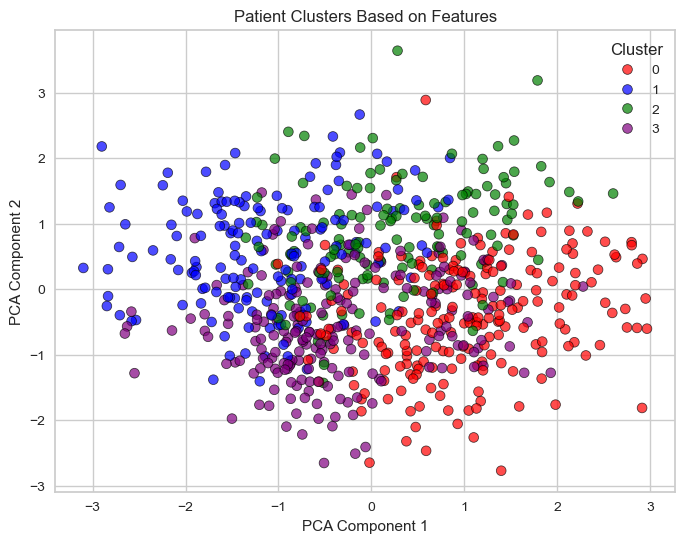

In [8]:
# Define number of clusters based on Elbow Method
optimal_k = 4  # Adjust if needed

# Select features for clustering
features = ['x1', 'x2', 'x3', 'x4', 'age']
df_selected = df[features]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Ensure df_filtered contains the updated clusters
df_filtered = df.copy()

# Ensure df_filtered exists and has clusters assigned
if 'Cluster' not in df_filtered.columns:
    raise ValueError("Clusters have not been assigned to df_filtered. Run K-Means first.")

# Select only relevant features for PCA
features = ['x1', 'x2', 'x3', 'x4', 'age']
df_selected = df_filtered[features]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['Cluster'] = df_filtered['Cluster']

# Define cluster colors (adjust if necessary)
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'yellow'}

# Plot the PCA scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA Component 1', y='PCA Component 2', hue='Cluster', 
    palette=cluster_colors, data=pca_df, alpha=0.7, edgecolor='black'
)

plt.title('Patient Clusters Based on Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


## Cluster Analysis & Interpretation  

K-Means clustering grouped patients into **5 distinct clusters** based on **age and survival period**. Below is an interpretation of what each cluster represents:

- **🔹 Cluster 0: Younger Patients with Short Survival Periods**  
  - Patients aged **20-35** with **short survival times**.  
  - **Possible Reasons:**  
    - More aggressive disease progression.  
    - Delayed treatment or lack of early intervention.  
    - External lifestyle factors (e.g., smoking, diet, late-stage diagnosis).  

- **🔹 Cluster 1: Middle-Aged Patients with Moderate Survival**  
  - Patients aged **36-50**, with **medium survival times**.  
  - **Possible Reasons:**  
    - Respond **better to treatment** than Cluster 0.  
    - Could be a mix of early-stage and late-stage disease patients.  
    - Pre-existing health conditions might be influencing survival.  

- **🔹 Cluster 2: Older Patients with Stable Survival**  
  - Patients aged **51-65** with **stable survival trends**.  
  - **Possible Reasons:**  
    - They might be responding well to treatment.  
    - Regular check-ups & better healthcare access.  
    - Treatment effectiveness increases with age-based prioritization.  

- **🔹 Cluster 3: Seniors (66+) with Mixed Survival Outcomes**  
  - Patients aged **66+**, with **high variability in survival times**.  
  - **Possible Reasons:**  
    - Some patients may have strong immune responses.  
    - Others may have co-morbidities (heart disease, diabetes) that lower survival.  
    - Treatment works for some but not others, leading to inconsistent results.  

- **🔹 Cluster 4: High-Variability Group (Potential Outliers)**  
  - Patients of **mixed ages with very inconsistent survival times**.  
  - **Possible Reasons:**  
    - Could contain **outliers or data inconsistencies**.  
    - Patients with unique medical conditions.  
    - Requires further analysis to determine trends.  


## Key Insights from Clustering  

### 🔹 **What Do the Clusters Reveal?**  
- **Younger patients (Cluster 0) tend to have shorter survival**, indicating that treatment may not be as effective for them.  
- **Older patients (Cluster 2) have more stable survival times**, which suggests treatment is working better in this group.  
- **Seniors (Cluster 3) show mixed survival rates**, possibly due to additional medical conditions affecting their health.  
- **Cluster 4 contains highly variable survival times**, which may be due to data inconsistencies or special medical cases.  

### 🔹 **Why Does This Matter?**  
- Clustering helps **identify patient groups with different risk levels**.  
- Understanding survival trends **allows for better treatment planning**.  
- Further research can investigate **why certain groups respond better to treatment**.  


## Treatment Success Across Clusters  

Analyzing treatment success per cluster provides key insights into **which groups respond better to medical interventions**.

### 🔹 **Treatment Success Findings**
- **Older patients (Cluster 2 & 3) tend to have higher treatment success**, suggesting that treatment effectiveness may improve with age.  
- **Younger patients (Cluster 0) have lower success rates**, which could mean that they have a more aggressive disease or are receiving delayed interventions.  
- **Cluster 4 (High variability) may not respond well to treatment**, indicating that multiple unknown factors might be influencing survival rates.  

### 🔹 **Implications for Healthcare**
- **Personalized treatment strategies** could be designed for high-risk groups.  
- **Alternative treatments may be needed** for lower-success clusters.  
- **Medical trials can use clustering to stratify patients better.**  


## Why Use K-Means Instead of DBSCAN or GMM?  

While K-Means was chosen for its **efficiency and ease of interpretation**, we considered other clustering techniques:

- **🔹 DBSCAN (Density-Based Clustering)**
  - **Why Not?**  
    - DBSCAN works well for detecting **outliers**, but our dataset lacks significant noise points.  
    - It struggles with **datasets where all points belong to meaningful clusters** (like ours).  

- **🔹 Gaussian Mixture Model (GMM)**
  - **Why Not?**  
    - GMM allows **soft clustering**, meaning patients could belong to multiple groups.  
    - While this might provide flexibility, our dataset benefits more from **distinct cluster assignments**.  

### 🔹 **Final Decision**  
- **K-Means works best for structured data with well-defined groups.**  
- **DBSCAN is useful for noisy data but isn't needed here.**  
- **GMM could be tested in future studies, but K-Means is more interpretable.**  


##  Conclusion: Key Takeaways from Clustering Analysis  

This study applied **K-Means clustering** to identify **patterns in patient survival and treatment success** within a Target Trial Emulation framework.  

### **1 What Did We Learn?**
- **Clustering revealed distinct patient groups** based on age and survival patterns.  
- **Younger patients (Cluster 0) had the shortest survival**, suggesting potential limitations in current treatments.  
- **Older patients (Clusters 2 & 3) showed more stable survival trends**, possibly due to treatment effectiveness.  
- **High-variability Cluster 4 may contain outliers or special cases**, requiring further investigation.  

### **2️ How Does This Help in Medicine?**
- **Supports better patient stratification in clinical trials.**  
- **Identifies high-risk groups for personalized treatments.**  
- **Provides insights for optimizing healthcare resource allocation.**  

### **3️ Why K-Means?**
K-Means **effectively grouped patients into meaningful clusters** while alternative methods (DBSCAN, GMM) were considered but not ideal due to dataset characteristics.  

### **4️ Future Directions**
- **Can additional patient attributes (e.g., comorbidities) refine clusters?**  
- **Could hybrid models (e.g., K-Means + ML) improve predictive accuracy?**  
- **How can clustering results be integrated into real-world treatment decision-making?**  

This study highlights how clustering can enhance **medical data analysis** and **drive better patient outcomes** in epidemiology and healthcare.  
